# Variational Bayesian Regression in Pyro

This notebook contains a quick toy example of univariate Bayesian linear regression, trained using variational inference, implemented in Pyro.

Firstly we generate some synthetic data by corrupting linear data with Gaussian noise.

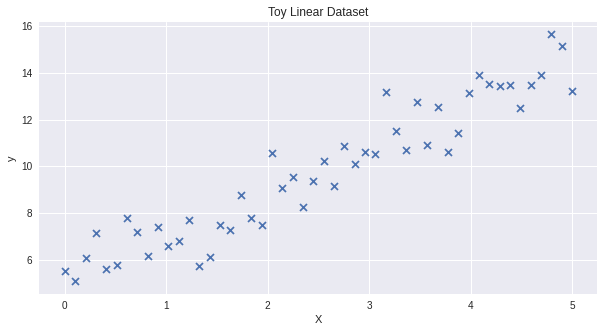

In [256]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
plt.style.use('seaborn')
np.random.seed(42)

# Generate linear data corrupted by N(0, 1) Gaussian noise
w_true = 2.0
c_true = 5.0
sigma2_true = 1.0
X = np.linspace(0, 5, 50)
y = (w_true * X) + c_true + np.random.normal(0, sigma2_true, size=50)

# Plot synthetic data
plt.figure(figsize=(10, 5))
plt.xlabel('X')
plt.ylabel('y')
plt.title('Toy Linear Dataset')
plt.scatter(X, y, marker='x')
plt.show()

# Convert data to tensors
X = torch.tensor(X, dtype=torch.float).reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float).reshape(-1, 1)

We can now define our linear model using Pyro, whereby instead of minimisng the squared error to obtain a maximum likelihood solution for the parameters, we will place priors over our parameters to give a full Bayesian treatment, deriving an approximate form of the posterior via variational inference (VI).

For simple models such as this, the exact form of the posterior is analytically obtainable, however in most probabilistic models of greater complexity the integral required to arrive at the model evidence is intractable, so deterministic approximation methods such as VI (or sampling-based methods such as MCMC) are required.

In [360]:
class BayesianRegression(PyroModule):
    def __init__(self, d_in, d_out):
        super().__init__()
        
        # Define linear model
        self.linear = PyroModule[nn.Linear](d_in, d_out) # Define linear model
        
        # Place normal priors over the gradient & intercept.
        # NOTE: Safest to assume dependence using `to_event(dim)`, more info at
        # https://pyro.ai/examples/tensor_shapes.html#It-is-always-safe-to-assume-dependence
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([d_out, d_in]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([d_out]).to_event(1))
        
    def forward(self, x, y=None):
        sigma2 = pyro.sample("sigma2", dist.Uniform(0., 5.))
        mu = self.linear(x).squeeze(-1)
        
        # This context manager denotes that the observations in x are conditionally
        # independent of one another, given the priors mu and sigma2
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma2), obs=y)
        
        return mu

Specifically, for inference we will use Stochastic VI (SVI), which seeks an approximate posterior with the lowest KL divergence wrt. the true posterior. We first instantiate our model and apply a guide which assumes all of the latent parameters in our BR model as uncorrelated. We then train our model using SVI and the Adam optimiser, monitoring the ELBO as our objective function.

In [372]:
# Instantiate model and guide
model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)

# Define optimiser and inference method of SVI
opt = pyro.optim.Adam({"lr": 0.025})
svi = SVI(model, guide, opt, loss=Trace_ELBO())

# Train the model for 250 iterations
pyro.clear_param_store()
for i in range(250):
    loss = svi.step(X, y)
    if i % 20 == 0:
        print('Step %d, Loss = %.3f' % (i + 1, loss/len(X)))

Step 1, Loss = 426.690
Step 21, Loss = 240.924
Step 41, Loss = 188.415
Step 61, Loss = 160.143
Step 81, Loss = 155.154
Step 101, Loss = 148.336
Step 121, Loss = 146.486
Step 141, Loss = 143.905
Step 161, Loss = 143.556
Step 181, Loss = 141.655
Step 201, Loss = 140.923
Step 221, Loss = 141.597
Step 241, Loss = 140.349


We can view the median and lower and upper quartile estimates for our parameters after training.

In [373]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma2': [tensor(3.8073, grad_fn=<AddBackward0>),
  tensor(3.8557, grad_fn=<AddBackward0>),
  tensor(3.9026, grad_fn=<AddBackward0>)],
 'linear.weight': [tensor([[1.6108]], grad_fn=<ViewBackward>),
  tensor([[1.6555]], grad_fn=<ViewBackward>),
  tensor([[1.7002]], grad_fn=<ViewBackward>)],
 'linear.bias': [tensor([4.4036], grad_fn=<ViewBackward>),
  tensor([4.4575], grad_fn=<ViewBackward>),
  tensor([4.5115], grad_fn=<ViewBackward>)]}

Next we use `Predictive` to generate 1000 samples from our trained model; this entails generating samples from unobserved sites in the guide and then conditioning said sites on sites sampled from the guide. We then use these samples to plot our regression line with confidence intervals.

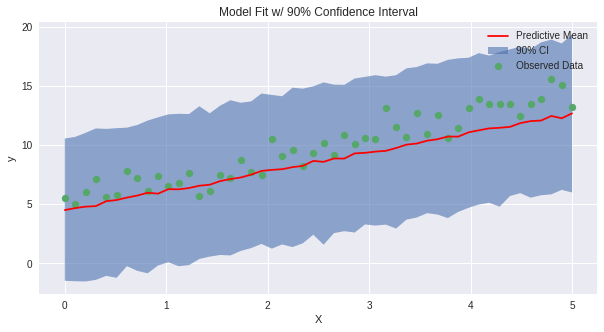

In [374]:
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=('obs', 'linear.weight',
                                      'linear.bias', '_RETURN'))
samples = predictive(X)

# Get summary statistics for plotting
def summary(samples):
    summary_stats = {}
    for name, vals in samples.items():
        summary_stats[name] = {
            'mu': torch.mean(vals, 0),
            'sigma2': torch.std(vals, 0),
            '5%': vals.kthvalue(int(len(vals) * 0.05), dim=0)[0],
            '95%': vals.kthvalue(int(len(vals) * 0.95), dim=0)[0]
        }
    return summary_stats

preds = summary(samples)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(X.detach().numpy(), preds['obs']['mu'].detach().numpy(),
         label='Predictive Mean', color='r')
plt.fill_between(X.detach().numpy().flatten(), preds['obs']['5%'].detach().numpy(),
                 preds['obs']['95%'].detach().numpy(), label='90% CI', alpha=0.6)
plt.scatter(X, y, label='Observed Data')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Model Fit w/ 90% Confidence Interval')
plt.show()